In [1]:
!pip install -U albumentations

In [2]:
# from tqdm.notebook import tqdm, trange
import os
from IPython.display import clear_output
import cv2 as cv
from PIL import Image
import matplotlib.pyplot as plt
from pathlib import Path
import random
import pickle
from functools import partial
import albumentations as A
import albumentations.pytorch as A_torch

import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.transforms import functional as F
from torchvision import models
# from torchsummary import summary

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
plt.style.use('ggplot')
%load_ext autoreload
%autoreload 2

In [3]:
def figsize(x, y):
    plt.figure(figsize=(x, y))

In [4]:
IMG_SIZE = 256, 256

In [239]:
x, y = next(iter(train_dl))

In [240]:
pred = (net(x.cuda())['out'].detach().cpu() > 0).numpy().astype('uint8')

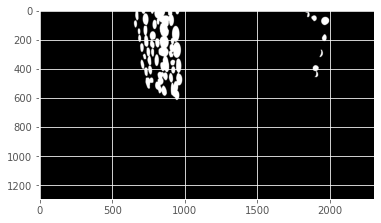

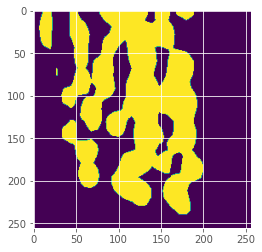

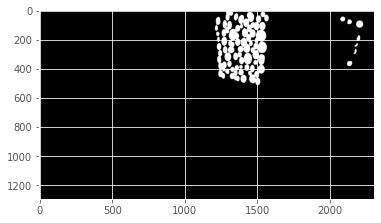

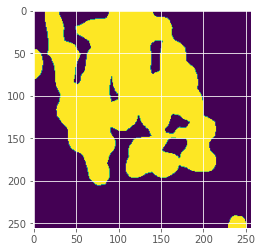

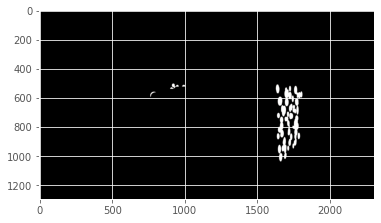

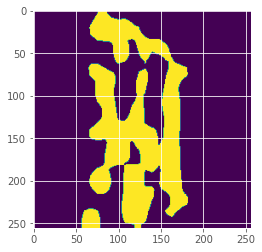

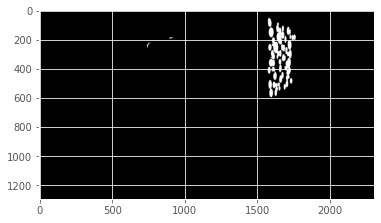

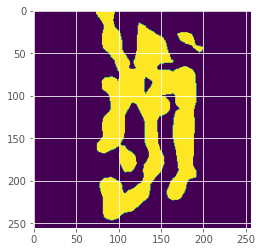

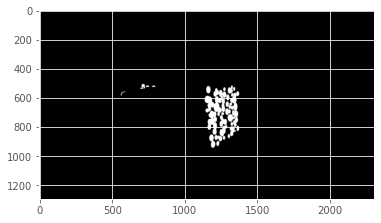

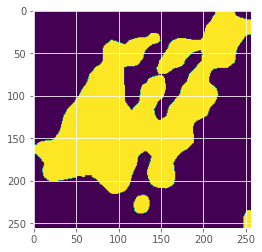

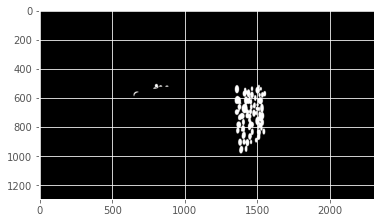

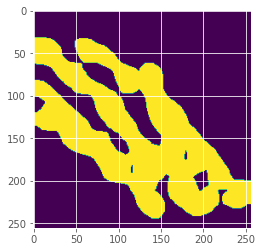

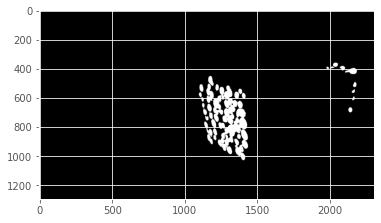

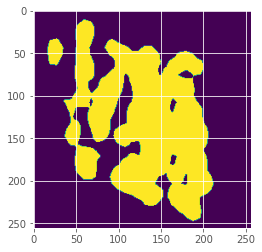

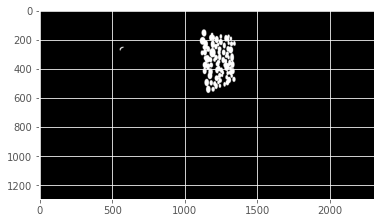

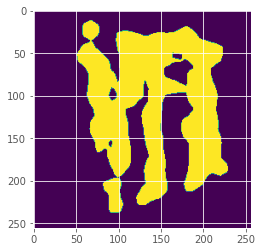

In [251]:
for (fname, pred_) in zip(train_filenames, pred):
    plt.imshow(plt.imread(str(fname).replace('.jpg', '_mask.jpg')))
    plt.show()
    plt.imshow(pred_[0])
    plt.show()

In [241]:
for x_, pred_ in zip(x, pred.squeeze()):
    spam = np.concatenate((x_, np.stack([pred_,pred_,pred_])), axis=2)
    plt.show(np.transpose(spam, (1, 2, 0)))

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [5]:
class TimberDS(Dataset):
    def __init__(self, filenames, butts_masks, transform, phase='train'):
        self.filenames = filenames
        self.butts_masks = butts_masks
        self.transform = transform
        self.phase = phase

        assert phase in ('train', 'val', 'test' ), 'Фаза должна быть `train`/`val`/`test`'

        
    def __getitem__(self, idx):
        filename = str(self.filenames[idx])
        butts_mask = self.butts_masks[idx]
        
        if self.phase in ('train', 'val'):
            img, mask = self.get_image_mask(filename, butts_mask)
            out_tensor, out_mask = self.apply_transform(img, mask)
            return out_tensor, (out_mask[None] > 127).float()

        elif self.phase == 'test':
            img = self.get_image(filename)
            return self.apply_transform(img)

    
    @staticmethod
    def get_image(filename: str):
        return cv.cvtColor(cv.imread(filename), cv.COLOR_BGR2RGB)

    @staticmethod
    def get_image_mask(filename: str, butts_mask):
        img = TimberDS.get_image(filename)
        
        butts_mask = cv.resize(butts_mask, img.shape[:2][::-1])
        nb_components, output, stats, centroids = cv.connectedComponentsWithStats(butts_mask)
        x, y, dx, dy, _ = stats[np.argsort(stats[:, -1])][-2]
        
        mask = cv.imread(filename.replace('.jpg', '_mask.jpg'), 0)
        img, mask = img[y:y+dy, x:x+dx], mask[y:y+dy, x:x+dx]
        _, w = img.shape[:2]
        return img, mask

    def apply_transform(self, img, mask=None):
        if self.phase in ('train', 'val'):
            transformed = self.transform(image=img, mask=mask)
            return transformed['image'], transformed['mask']

        elif self.phase == 'test':
            transformed = self.transform(image=img)
            return transformed['image']

    def __len__(self):
        return len(self.filenames)

In [6]:
# путь к изображениям
PATH = Path('data/segm_butts_dotted')

In [149]:
# train_filenames = [fn for fn in (DATA_PATH / '2').glob('*.jpg')
#                   if not fn.stem.endswith('mask1') 
#                   if not fn.stem.endswith('mask2')]

# val_filenames = [fn for fn in (DATA_PATH / '3').glob('*.jpg')
#                   if not fn.stem.endswith('mask1') 
#                   if not fn.stem.endswith('mask2')]

In [7]:
train_filenames = val_filenames = [i for i in PATH.glob('*.jpg') if 'mask' not in i.name]

In [111]:
# path = Path(DATA_PATH)
# filenames = [fn for fn in path.glob('**/*.jpg')
#                   if not fn.stem.endswith('mask1') 
#                   if not fn.stem.endswith('mask2')]

# train_filenames = [fn for fn in filenames 
#                       if fn.stem.startswith('8011') or fn.stem.startswith('8010')]

# val_filenames = [fn for fn in filenames 
#                       if fn.stem.startswith('8006') or fn.stem.startswith('8007')]

In [8]:
def thresh(x, **kwargs):
    return cv.threshold(x,127,255,cv.THRESH_BINARY)[1]

train_transform = A.Compose([
    A.ShiftScaleRotate(rotate_limit=30, shift_limit_x=0.5, shift_limit_y=0.5),
    # A.RandomSizedCrop((800, 1200), 256, 256, p=0.2),
    # A.RandomCrop(width=1500, height=800, p=0.4),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    # A.RandomBrightnessContrast(p=0.1),
    # A.ElasticTransform(p=0.1),
    # A.ChannelShuffle(p=0.1),
    A.Resize(256, 256),
    A.Lambda(mask=thresh),
    A.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    ),
    A_torch.ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    ),
    A_torch.ToTensorV2()                      
])

Берём модель, предсказывающую область с торцами

In [9]:
net = torch.load('fcn_resnet.pth')

In [10]:
butts_masks = []
for filename in map(str,train_filenames):
    img = TimberDS.get_image(filename)
    tensor = val_transform(image=img)['image']
    segm_buts = (net(tensor[None].cuda())['out'].detach().cpu().numpy()[0,0] > 0).astype('uint8')
    butts_masks.append(segm_buts)

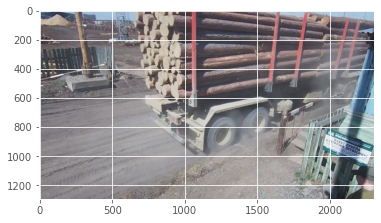

In [13]:
plt.imshow(plt.imread(train_filenames[0]))

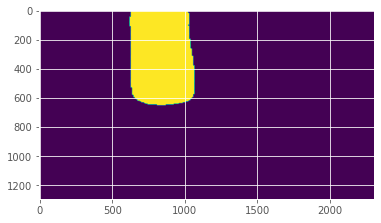

In [15]:
plt.imshow(cv.resize(butts_masks[0], (2304, 1296)))

In [16]:
train_ds = TimberDS(train_filenames, butts_masks, train_transform, phase='train')
val_ds = TimberDS(val_filenames, butts_masks, val_transform, phase='val')

train_dl = DataLoader(train_ds, batch_size=8, shuffle=False, drop_last=True)
val_dl = DataLoader(val_ds, batch_size=8, shuffle=True)

In [17]:
def to_numpy(input_tensor: torch.Tensor):
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    image = input_tensor.permute(1, 2, 0).numpy()
    image = std * image + mean
    return image.clip(0, 1)

to_pil = F.to_pil_image

In [18]:
def show_images(images: torch.Tensor, masks: torch.Tensor, figsize=(14, 8)):
    for image, mask in zip(images, masks):
        _, ax = plt.subplots(ncols=2, figsize=figsize)
        image = to_numpy(image)
        mask = to_pil(mask)

        ax[0].imshow(image)
        ax[1].imshow(mask)

        for a in ax:
            a.grid(False)
        plt.show()

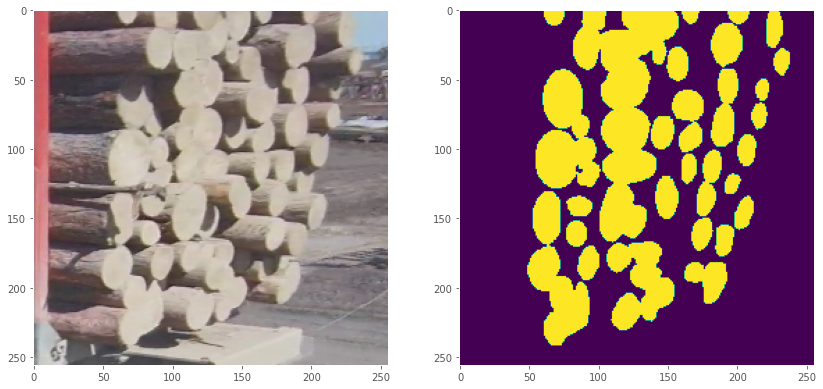

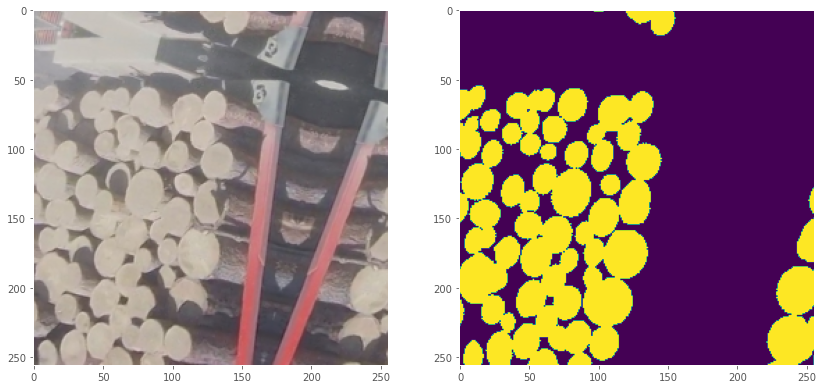

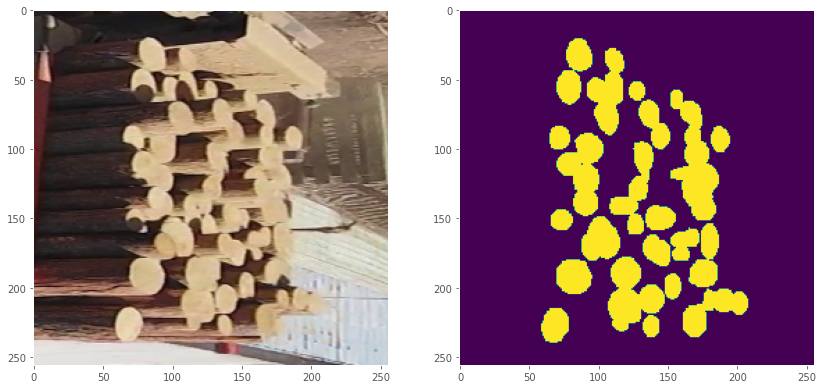

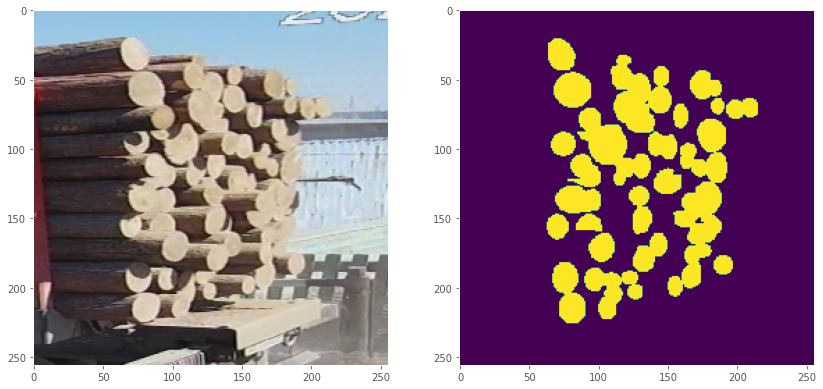

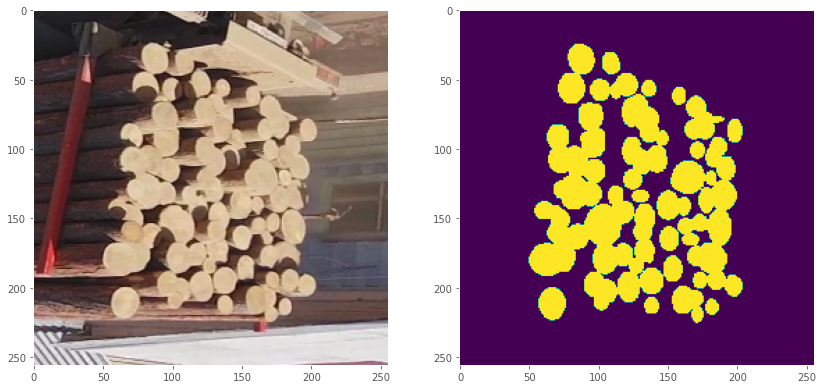

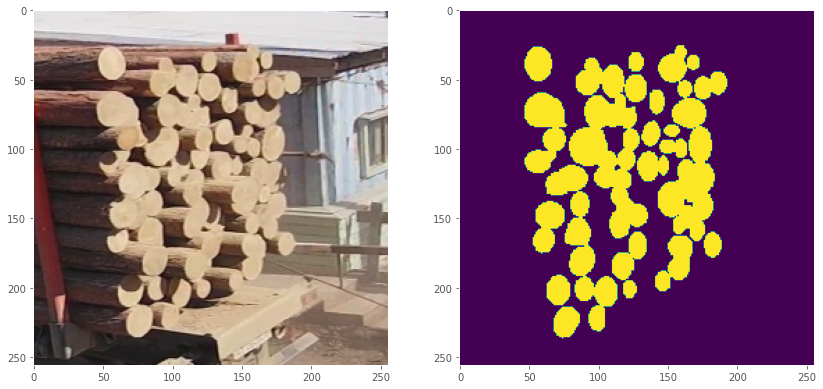

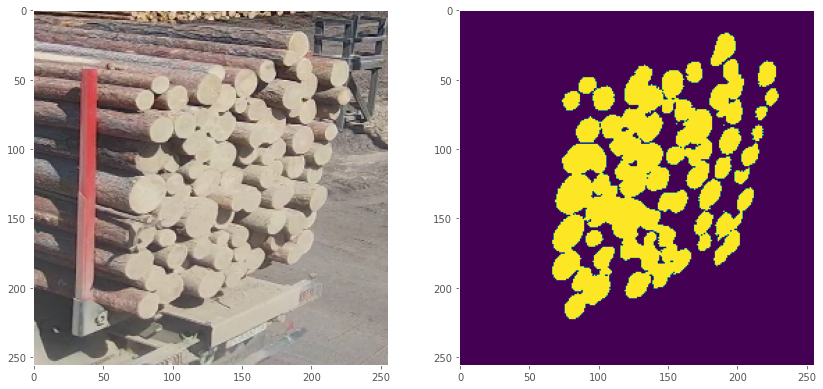

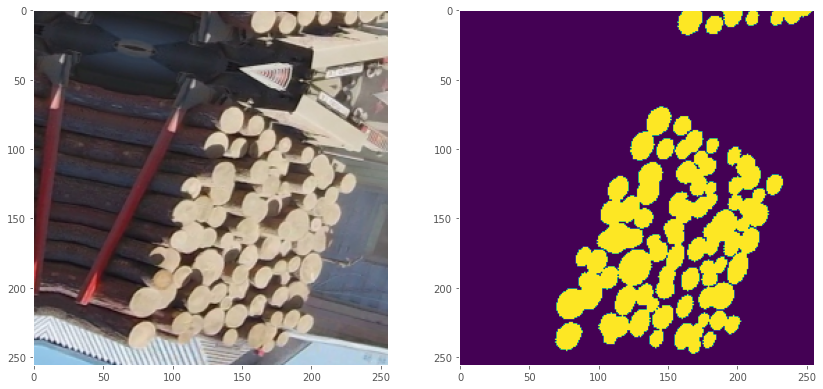

In [19]:
show_images(*next(iter(train_dl)))

In [20]:
from torchvision.models.segmentation import fcn_resnet50
net = fcn_resnet50(pretrained=True)

# for param in net.parameters():
#     param.requires_grad = False

# net.backbone.layer3.requires_grad_()
# net.backbone.layer4.requires_grad_()
# net.classifier.requires_grad_()

net.classifier[4] = nn.Sequential(
    nn.Conv2d(512, 1, kernel_size=(1, 1), stride=(1, 1)),
)

net.to(device);

In [21]:
# plot learning curves
def plot_lc(tr_loss, val_loss):
    fig, ax = plt.subplots(figsize=(8,6))
    ax.plot(tr_loss, label='Train loss')
    ax.plot(val_loss, label='Val loss')
    ax.set_xlabel('Num epoch')
    ax.set_ylabel('Loss')
    plt.axis('on')
    ax.legend()
    plt.show()

# returns original mask and predicted mask
def inference_batch(model, dataloader):
    model.eval()
    X, y = next(iter(dataloader))
    with torch.no_grad():
        y_pred = model(X.cuda())['out'].cpu()
    return y, y_pred

def show_masks(y, y_pred):
    fig, axes = plt.subplots(2, 5, figsize=(25,6));
    for i, ax in enumerate(axes.transpose()):
        ax[0].set_title('original mask')
        ax[0].imshow(y[i][0])
        ax[0].axis('off')

        ax[1].set_title('predicted mask')
        ax[1].imshow(y_pred[i][0].numpy())
        ax[1].axis('off')


    fig.suptitle(f'Epoch: {len(tr_loss)} Train loss: {tr_loss[-1]:.3f}/ Val loss: {val_loss[-1]:.3f}')
    plt.grid()
    plt.show()


# fitting epoch/evalute
def forward_epoch(model, loss_fn, opt, dataloader, steps, losses, phase):
    if phase == 'train':
        model.train()
    else:
        model.eval()
    
    epoch_loss = 0.
    for step, (X, y) in enumerate(dataloader):
        X = X.to(device)
        y = y.to(device)
        opt.zero_grad()

        with torch.set_grad_enabled(phase == 'train'):
            y_pred = model(X)['out']
            loss = loss_fn(y_pred, y)

            if phase == 'train':
                loss.backward()
                opt.step()
            
            epoch_loss += loss.item()
        if step + 1 == steps: 
            break
    losses.append(epoch_loss / len(dataloader))

def train(model, loss_fn, opt, num_epoch, train_dl, val_dl, scheduler=None, train_steps=None, val_steps=None):
    # t = trange(num_epoch, unit='epoch')
    for epoch in range(num_epoch):
        forward_epoch(model, loss_fn, opt, train_dl, train_steps, tr_loss, phase='train')
        forward_epoch(model, loss_fn, opt, val_dl, val_steps, val_loss, phase='val')

        if scheduler is not None:
            scheduler.step(val_loss[-1])
        y, y_pred = inference_batch(model, val_dl)

        clear_output()
        show_masks(y, y_pred)
        plot_lc(tr_loss, val_loss)

        global last_min_loss
        if val_loss[-1] < last_min_loss:
            last_min_loss = val_loss[-1]
            torch.save(model, save_path)
            print('Model saved')
        # t.set_description(f'{tr_loss[-1]:.3f}/{val_loss[-1]:.3f}')
        # t.update(1)

In [23]:
loss_fn = nn.BCEWithLogitsLoss()
opt = torch.optim.Adam(net.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, patience=5)
save_path = 'segm_butts_dotted.pth'

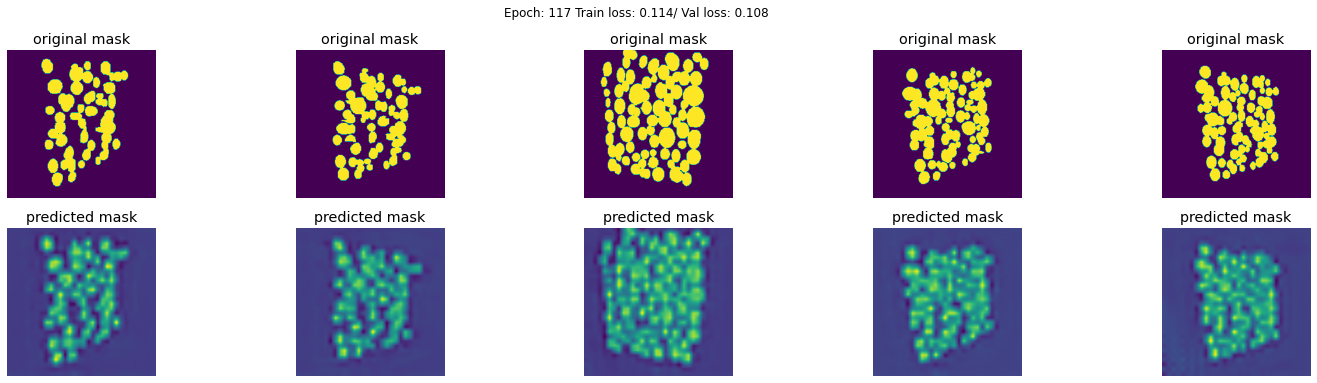

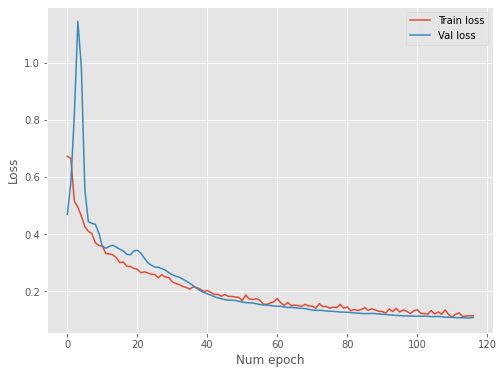

KeyboardInterrupt: 

In [32]:
if False:
    tr_loss, val_loss = [], []
    last_min_loss =  float('inf')

train(net, loss_fn, opt, 100, train_dl, val_dl, scheduler=scheduler)

In [300]:
net = torch.load('fcn_resnet.pth')

In [33]:
def iou_score(y_true: torch.Tensor, y_pred: torch.Tensor):
    inter = (y_true & y_pred).sum()
    union = (y_true | y_pred).sum()

    return inter / (union + 1e-8)

In [34]:
def score_model(model, metric, data):
    model.eval()  # testing mode
    scores = 0.
    with torch.no_grad():
        for X_batch, Y_label in data:
            Y_pred = model(X_batch.to(device))['out'].cpu() > 0
            Y_label = Y_label.long()
            scores += metric(Y_label, Y_pred)
    return (scores / len(data)).item()

In [35]:
train_iou = score_model(net, iou_score, train_dl)
val_iou = score_model(net, iou_score, val_dl)

print('Train IoU:', round(train_iou, 2))
print('Val IoU:', round(val_iou, 2))

Train IoU: 0.84
Val IoU: 0.85


In [ ]:
!mv /content/fcn_resnet50.pth drive/MyDrive/лесовозы/fcn_resnet50_96.pth

In [36]:
def show_predictions(X, y, y_pred):
    for X1, y1, y1_pred in zip(X, y, y_pred):
        _, ax = plt.subplots(ncols=3, figsize=(20,8))
        img = to_numpy(X1)
        ax[0].imshow(img)
        ax[0].set_title('Изображение')
        ax[1].imshow(cv.bitwise_and(img, img, mask=(y1[0].numpy().astype('uint8'))))
        ax[1].set_title('Реальная маска')
        ax[2].imshow(cv.bitwise_and(img, img, mask=(y1_pred[0].numpy() > 0).astype('uint8')))
        ax[2].set_title('Предсказанная маска')
        for a in ax: a.grid()
        plt.show()

In [ ]:
def show_predictions_test(X, y_pred):
    for X1, y1_pred in zip(X, y_pred):
        _, ax = plt.subplots(ncols=3, figsize=(20,8))
        img = to_numpy(X1)
        ax[0].imshow(img)
        ax[0].set_title('Изображение')
        ax[2].imshow(cv.bitwise_and(img, img, mask=(y1_pred[0].numpy() > 0).astype('uint8')))
        ax[2].set_title('Предсказанная маска')
        for a in ax: a.grid()
        plt.show()

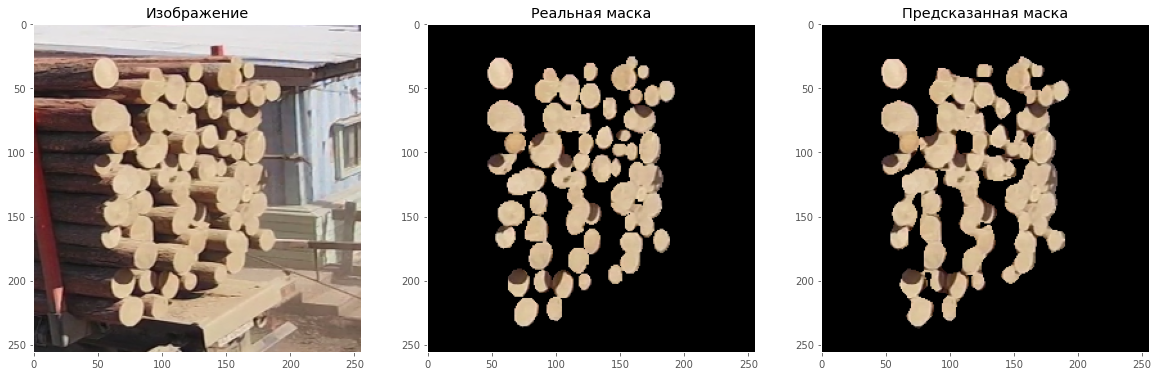

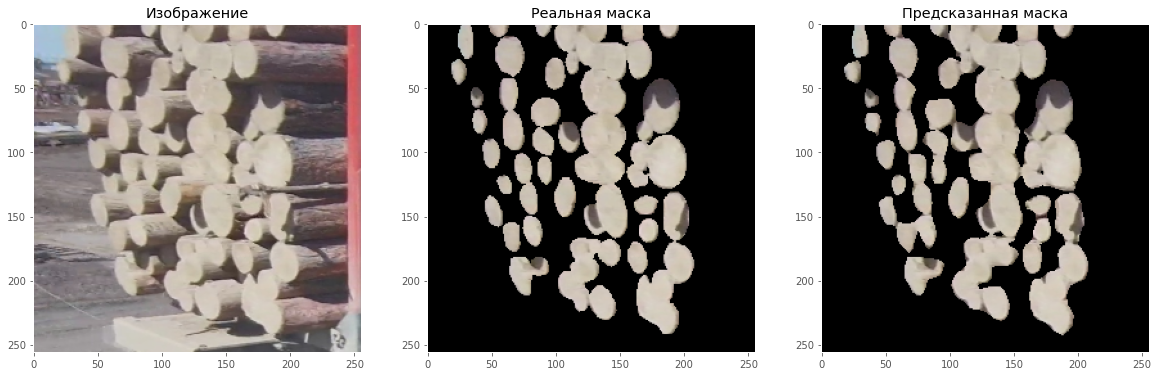

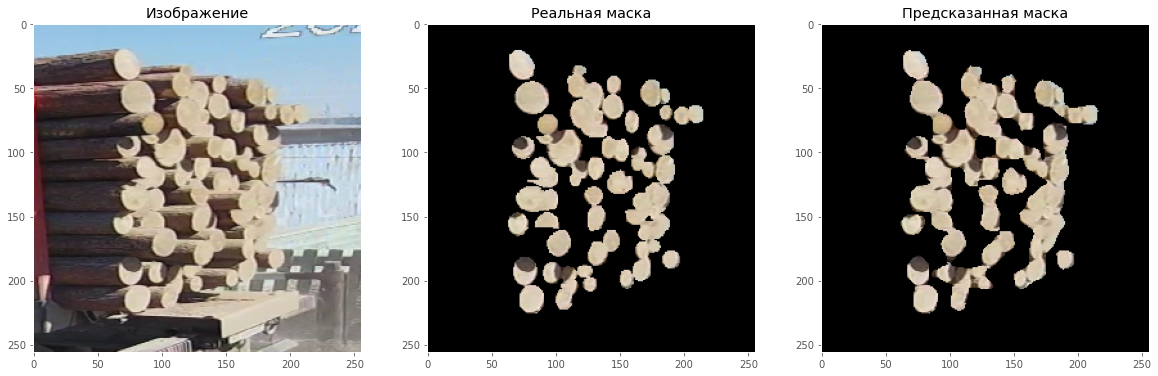

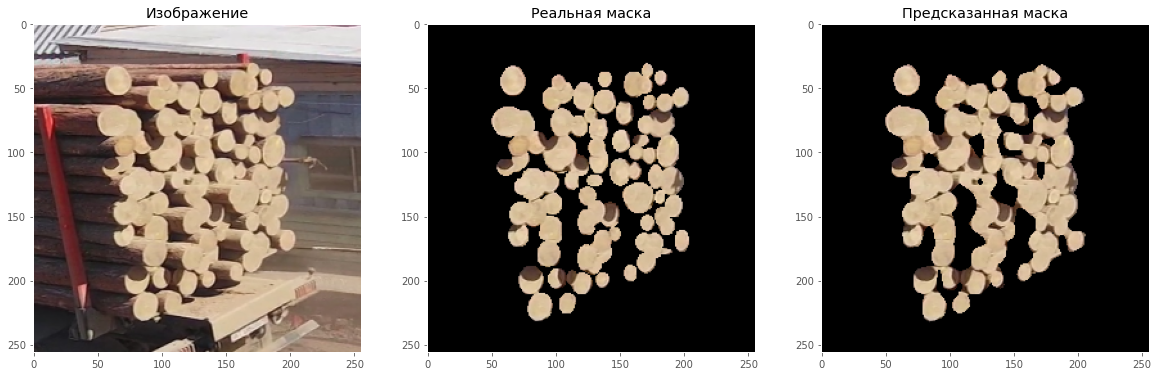

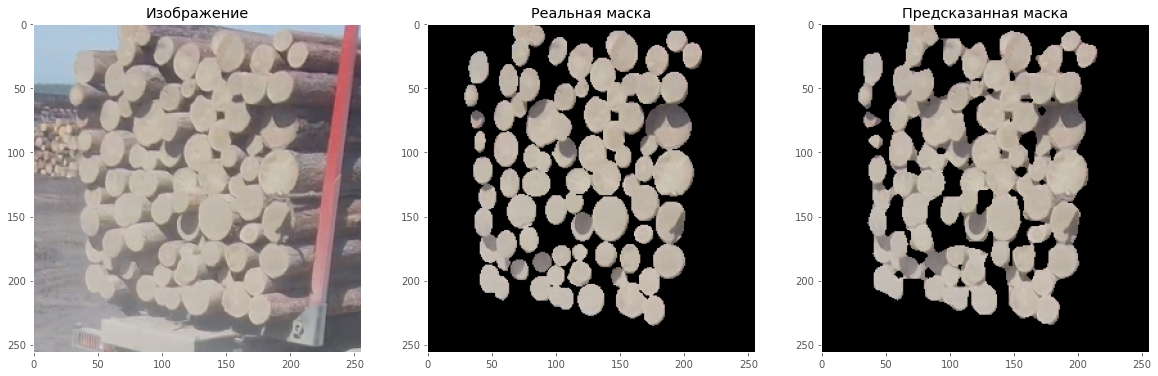

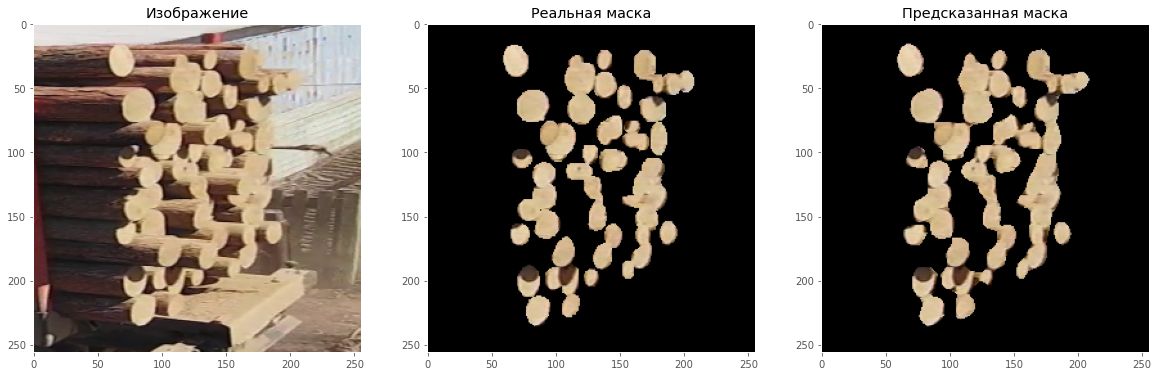

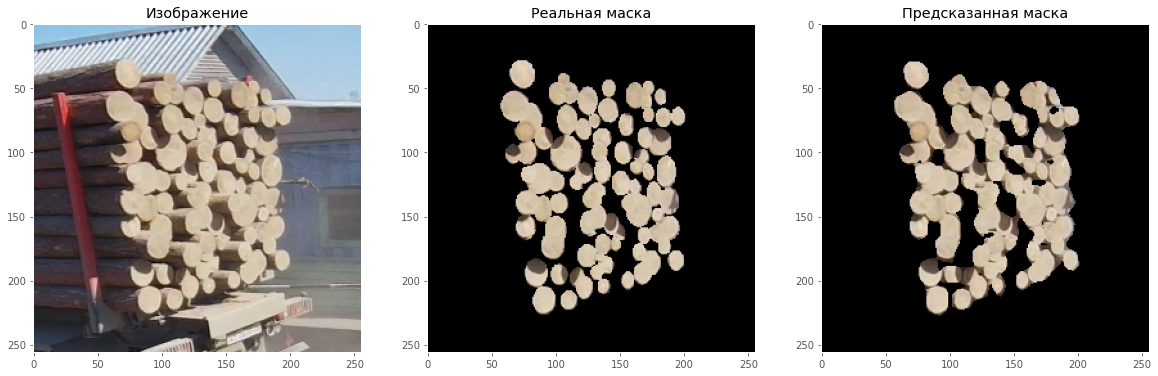

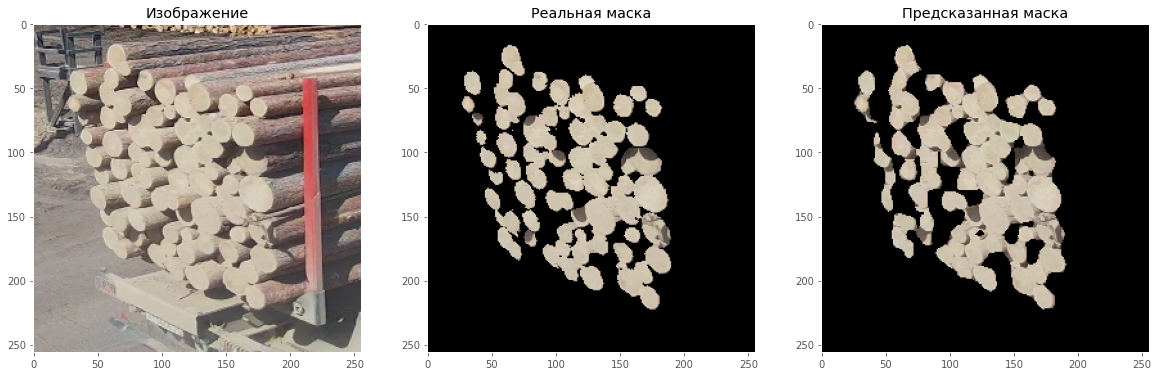

In [37]:
with torch.no_grad():
    X, y = next(iter(val_dl))
    y_pred = net(X.cuda())['out'].cpu()
    show_predictions(X, y, y_pred)